This notebook is used to postprocess and compare the LE simulations of different modeling configurations

In [1]:
# TODO: A more generic way is needed here to load the path
import sys

sys.path.append(
    # "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
    "/global/cfs/cdirs/m1800/peishi/jax-watershed/src"
)

In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import pickle
from functools import partial

import equinox as eqx
import numpy as np
import jax.numpy as jnp

import jax
import pandas as pd
from jax_canoak.subjects import get_met_forcings, get_obs, initialize_parameters
from jax_canoak.shared_utilities import compute_metrics
from jax_canoak.subjects import convert_met_to_batched_met
from jax_canoak.subjects import (
    # convert_batchedstates_to_states,
    convert_obs_to_batched_obs,
)

from jax_canoak.models import get_canle, update_canle
from jax_canoak.models import CanoakIFT, CanoakLeafRHHybridIFT
from jax_canoak.models import load_model, save_model

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import (
    plot_imshow,
    plot_imshow2,
    plot_imshow2b,
    plot_timeseries_obs_1to1,
    plot_timeseries,
    plot_flux_modis_obs,
    plot_obs_1to1,
    get_time
)

import seaborn as sns

%load_ext autoreload
%autoreload 2


In [3]:
# # Plotting parameters
# # rc('text', usetex=False)
# small_size = 15
# medium_size = 25
# bigger_size = 30
# plt.rc('font', size=small_size)          # controls default text sizes
# plt.rc('axes', titlesize=small_size)    # fontsize of the axes title
# plt.rc('axes', labelsize=small_size)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
# plt.rc('legend', fontsize=small_size)    # legend fontsize
# plt.rc('figure', titlesize=small_size)  # fontsize of the figure title
# plt.rc('text', usetex = False)

# Files and folders

In [4]:
site = "US-Hn1"
model_names = ['default', 'purephysics', 'hybridRH', 'dl']
model_labels = ['Default', 'Process-based', 'Hybrid', 'DNN']
model_colors = ['grey', 'tan', 'tab:blue', 'orange']

# Data in the calibration period
f_forcing = f"../../data/fluxtower/{site}/{site}-forcings-v2.csv"
# f_obs = "../../data/fluxtower/US-Hn1/US-Hn1-fluxes.csv"
f_obs = f"../../data/fluxtower/{site}/{site}-fluxes-nonegle-v2.csv"

# Data in the test period
f_forcing_test = f"../../data/fluxtower/{site}/{site}-forcings-test-v2.csv"
f_obs_test = f"../../data/fluxtower/{site}/{site}-fluxes-nonegle-test-v2.csv"

# Model files
f_models = [f"{site}_{m}_model.eqx" for m in model_names if m != 'dl']

# Model outputs/configurations
f_model_configs = [f"{site}_{m}.pkl" for m in model_names]


# Load models

In [5]:
models = {}
for i,f_model in enumerate(f_models):
    name = model_names[i]
    if name != 'hybridRH':
        models[name] = load_model(f_model, CanoakIFT)
    else:
        models[name] = load_model(f_model, CanoakLeafRHHybridIFT)
    

# Load model outputs/configurations

In [6]:
configs = {}
for i,f_model_config in enumerate(f_model_configs):
    name = model_names[i]
    configs[name] = pickle.load(open(f_model_config, "rb"))
    

In [7]:
# Rename
configs['dl']['train']['can.LE'] = configs['dl']['train'].pop('LE')
configs['dl']['test']['can.LE'] = configs['dl']['test'].pop('LE')


# Load focings and observations

In [8]:
# Train
obs = get_obs(f_obs)
met, n_time = get_met_forcings(f_forcing)

# Test
obs_test = get_obs(f_obs_test)
met_test, n_time_test = get_met_forcings(f_forcing_test)


/global/cfs/cdirs/m1800/peishi/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)
/global/cfs/cdirs/m1800/peishi/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


In [9]:
# Combine train and test
met_all = jax.tree_util.tree_map(
    lambda train, test: jnp.concatenate([train, test]), met, met_test
)
obs_all = jax.tree_util.tree_map(
    lambda train, test: jnp.concatenate([train, test]), obs, obs_test
)
met_all, obs_all


(Met(
   zL=f32[35040],
   year=f32[35040],
   day=f32[35040],
   hhour=f32[35040],
   T_air=f32[35040],
   rglobal=f32[35040],
   eair=f32[35040],
   wind=f32[35040],
   CO2=f32[35040],
   P_kPa=f32[35040],
   ustar=f32[35040],
   Tsoil=f32[35040],
   soilmoisture=f32[35040],
   zcanopy=f32[35040],
   lai=f32[35040]
 ),
 Obs(
   P=f32[35040],
   LE=f32[35040],
   H=f32[35040],
   GPP=f32[35040],
   rnet=f32[35040],
   albedo=f32[35040],
   Fco2=f32[35040],
   gsoil=f32[35040],
   Rsoil=f32[35040]
 ))

In [10]:
# le_train = pd.DataFrame(
#     data={
#         "obs": obs.LE,
#         key1: out1["train"]["can.LE"],
#         key2: out2["train"]["LE"],
#         key3: out3["train"]["can.LE"],
#     },
#     index=out1["train"]["time"],
# )
# le_test = pd.DataFrame(
#     data={
#         "obs": obs_test.LE,
#         key1: out1["test"]["can.LE"],
#         key2: out2["test"]["LE"],
#         key3: out3["test"]["can.LE"],
#     },
#     index=out1["test"]["time"],
# )

/global/cfs/cdirs/m1800/peishi/jax-watershed/src/jax_canoak/shared_utilities/plot.py:878: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(axes[-1].get_xticklabels(), rotation=15, ha="right");


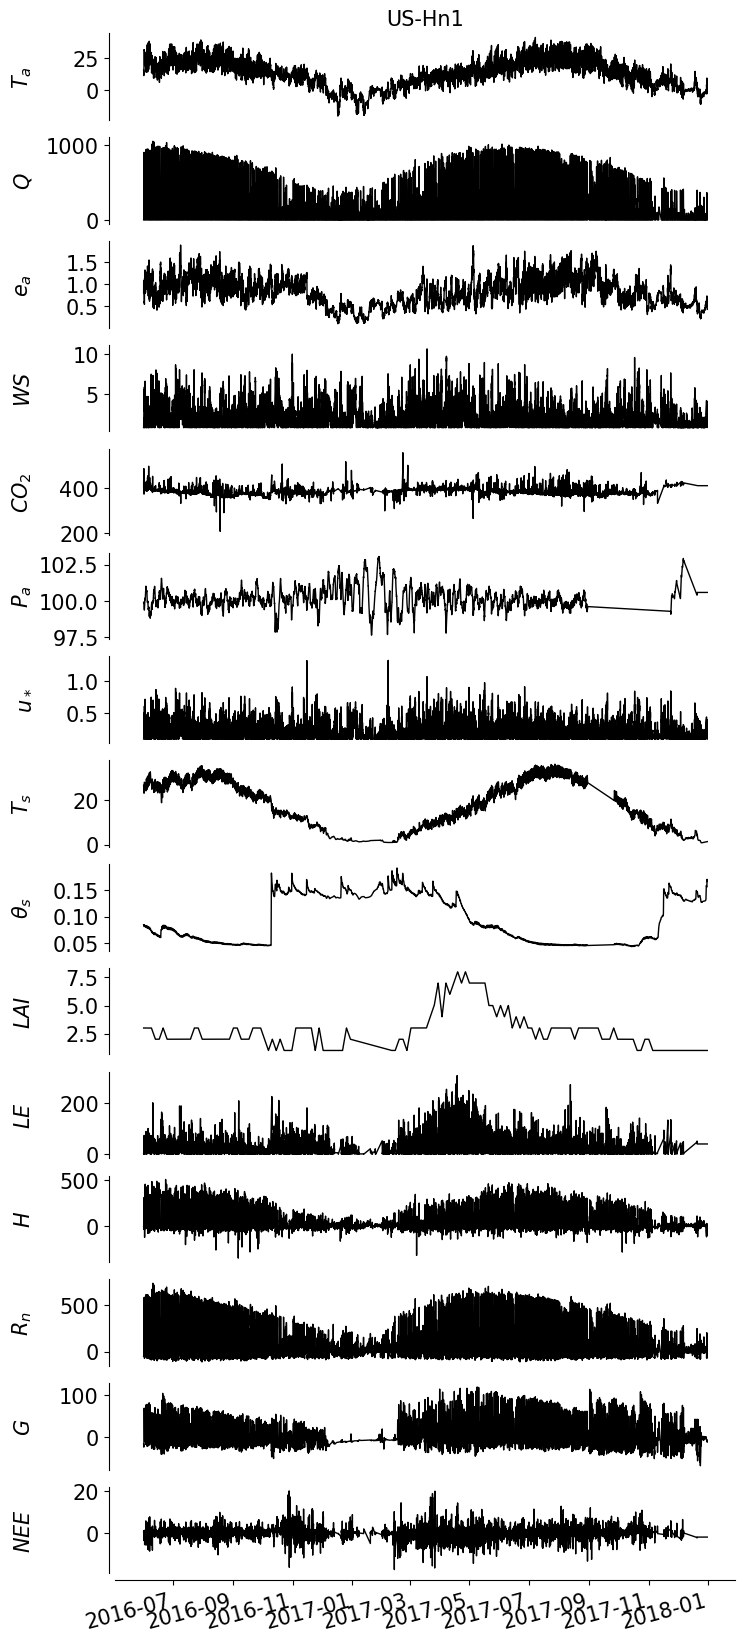

In [61]:
# Plot flux tower/MODIS data
plot_flux_modis_obs(obs, met, site)

# Run the models

In [12]:
sim = {}
for name in model_names[:-1]:
    sim[name] = models[name](met)


# Local sensitivity analysis

In [13]:
jax.clear_caches()

@eqx.filter_jit
@partial(jax.grad, argnums=0)
def df_canoak_le(para, met, canoak_eqx):
    canoak_eqx = eqx.tree_at(lambda t: t.para, canoak_eqx, para)
    can_le = canoak_eqx.get_fixed_point_states(met, update_canle, get_canle)
    # met, update_soilresp, get_soilresp)
    return can_le.sum()


@eqx.filter_jit
def df_canoak_le_batched(para, batched_met, canoak_eqx):
    def compute_grad(para, met):
        grad = df_canoak_le(para, met, canoak_eqx)
        return para, grad

    _, gradients = jax.lax.scan(compute_grad, para, xs=batched_met)
    return gradients

# eqx.filter_make_jaxpr(df_canoak_le3)(para, met, canoak_eqx)


In [14]:
jax.clear_caches()

batched_met_sa = convert_met_to_batched_met(met, n_time, 1)
gradients = {}
for name in model_names[:-1]:
    model = models[name]
    gradients[name] = df_canoak_le_batched(model.para, batched_met_sa, model)


In [51]:
# gradients[name]

In [77]:
# plt.plot(sim['purephysics'][0][4].Leaf_RH.mean(axis=1))

In [37]:
# plt.scatter(obs.Fco2, sim[''][0][-1].NEE)
# plt.plot(sim['purephysics'][0][-1].NEE, '.')

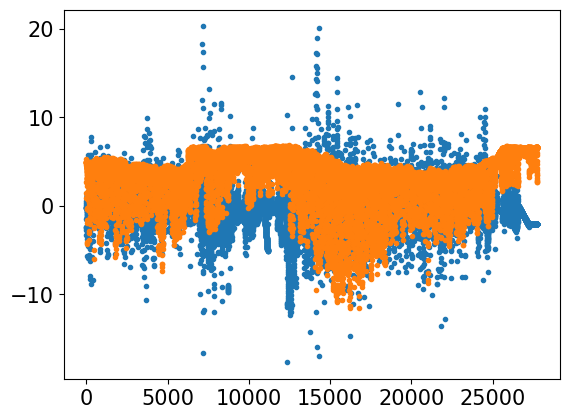

In [35]:
# plt.plot(sim['hybridRH'][0][4].Leaf_RH.mean(axis=0))
plt.plot(obs.Fco2, '.')
plt.plot(sim['purephysics'][0][-1].NEE, '.')

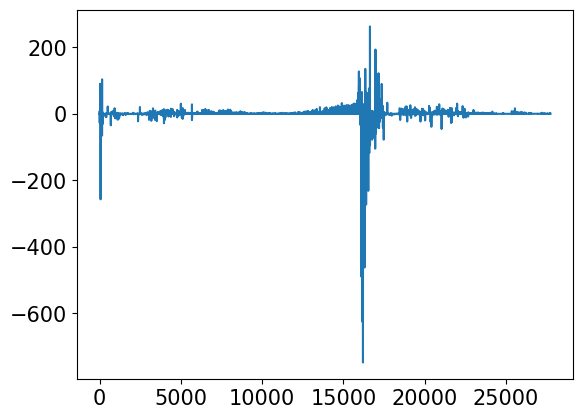

In [22]:
# plt.plot(gradients[name].LeafRHDL.layers[0].weight.mean(axis=(1,2)))
plt.plot(gradients['hybridRH'].kball)
# plt.imshow(sim['hybridRH'][0][4].Leaf_RH.T, aspect='auto', cmap='Blues')

/tmp/ipykernel_2051892/2838667974.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
/tmp/ipykernel_2051892/2838667974.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")


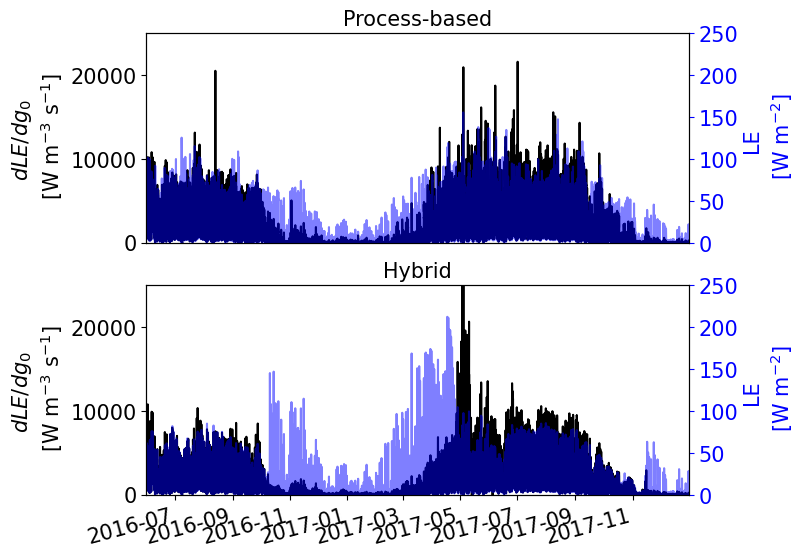

In [65]:
times = get_time(met)
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=False)
# # Flux tower observations
# ax = axes[0]
# ax_twinx = ax.twinx()
# plot_timeseries(
#     met.soilmoisture, times, ax=ax, title='', alpha=0.5, color='blue', tunit="[day of year]", xticks=[]
# )
# plot_timeseries(
#     # met.vpd_Pa, times, ax=ax_twinx, title='', alpha=.5, color='black', tunit="[day of year]", xticks=[]
#     obs.LE, times, ax=ax_twinx, title='', alpha=.5, color='black', tunit="", xticks=[]
# )
# ax.set(xlabel='', ylabel='SWC [m3 m-3]', title='Flux tower observations')
# ax.yaxis.label.set_color('blue')
# ax.tick_params(axis='y', colors='blue')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
# ax_twinx.set(xlabel='', ylabel='LE [W m-2]')
# ax_twinx.yaxis.label.set_color('grey')
# ax_twinx.tick_params(axis='y', colors='grey')


for i,ax in enumerate(axes):
    name = model_names[i+1]
    label = model_labels[i+1]
    plot_timeseries(
        gradients[name].bprime, times, ax=ax, title=f'{label}', alpha=1., color='black', tunit="[day of year]"
    )
    ax.set(xlabel='', ylabel='$dLE/dg_0$ \n [W m$^{-3}$ s$^{-1}$]', ylim=[-100, 25000])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
    
    ax_twinx = ax.twinx()
    plot_timeseries(
        configs[name]['train']['can.LE'], times, ax=ax_twinx, alpha=.5, color='blue', tunit="[day of year]"
    )
    ax_twinx.set(xlabel='', ylabel='LE \n [W m$^{-2}$]',  ylim=[0, 250])
    ax_twinx.yaxis.label.set_color('blue')
    ax_twinx.tick_params(axis='y', colors='blue')

axes[0].set_xticks([])
plt.show();


# Performances

## Compute the performances

In [30]:
metrics_keys = ["rmse", "mse", "r2", "kge", "mkge", "cc", "nse"]
metrics_df = pd.DataFrame(columns=metrics_keys, index=model_names)
metrics_test_df = pd.DataFrame(columns=metrics_keys, index=model_names)
for name in model_names:
    metrics = compute_metrics(obs.LE, configs[name]['train']['can.LE'])
    metrics_test = compute_metrics(obs_test.LE, configs[name]['test']['can.LE'])
    for m in metrics_keys:
        metrics_df.loc[name, m] = metrics[m]
    for m in metrics_keys:
        metrics_test_df.loc[name, m] = metrics_test[m]
        

In [31]:
metrics_df

,rmse,mse,r2,kge,mkge,cc,nse
default,121.567928,14778.761026,-13.891494,-0.138712,0.116998,0.464829,-0.091626
purephysics,29.61952,877.315946,0.115992,0.222094,0.320697,0.490203,-0.687682
hybridRH,27.25387,742.773437,0.251561,0.298299,0.346654,0.602032,-0.247743
dl,18.811809,353.884162,0.643416,0.68998,0.69897,0.802191,0.453026


In [32]:
# metrics_test_df

## Comparing the estimated parameters

In [33]:
for name in model_names[:-1]:
    t = models[name]
    print(f"Parameters of {name} model -- ")
    print(f"bprime: {t.para.bprime}; lleaf: {t.para.lleaf}; qalpha: {t.para.qalpha}; kball: {t.para.kball}.")

Parameters of default model -- 
bprime: 0.05000000074505806; lleaf: 0.03999999910593033; qalpha: 0.2199999988079071; kball: 8.170000076293945.
Parameters of purephysics model -- 
bprime: 0.004599814303219318; lleaf: 0.10000000149011612; qalpha: 0.07863274961709976; kball: 7.952610969543457.
Parameters of hybridRH model -- 
bprime: 0.005557416472584009; lleaf: 0.10000000149011612; qalpha: 0.14768408238887787; kball: 8.014809608459473.


## Loss function

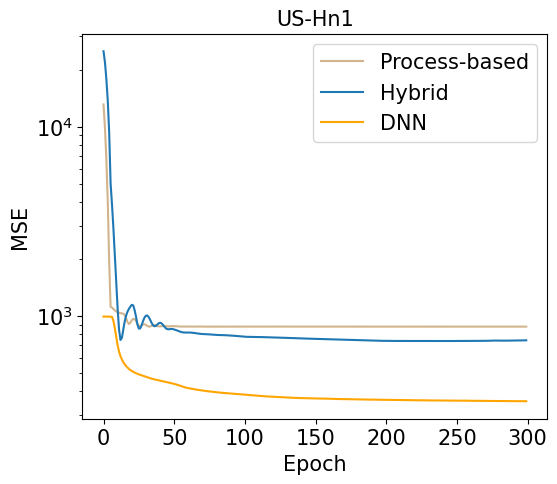

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))
for i in range(1,4):
    label, name, color = model_labels[i], model_names[i], model_colors[i]
    ax.plot(configs[name]['train']['loss'], color=color, label=f"{label}")
    # ax.plot(configs[name]['test']['loss'], linestyle='--', color=color, label=f"{name}-test")
ax.set(xlabel='Epoch', ylabel='MSE', yscale='log', title=site)
ax.legend()
plt.show()


## Plot ET time series

/tmp/ipykernel_911035/1434804694.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=20, ha="right")
/tmp/ipykernel_911035/1434804694.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=20, ha="right")
/tmp/ipykernel_911035/1434804694.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=20, ha="right")


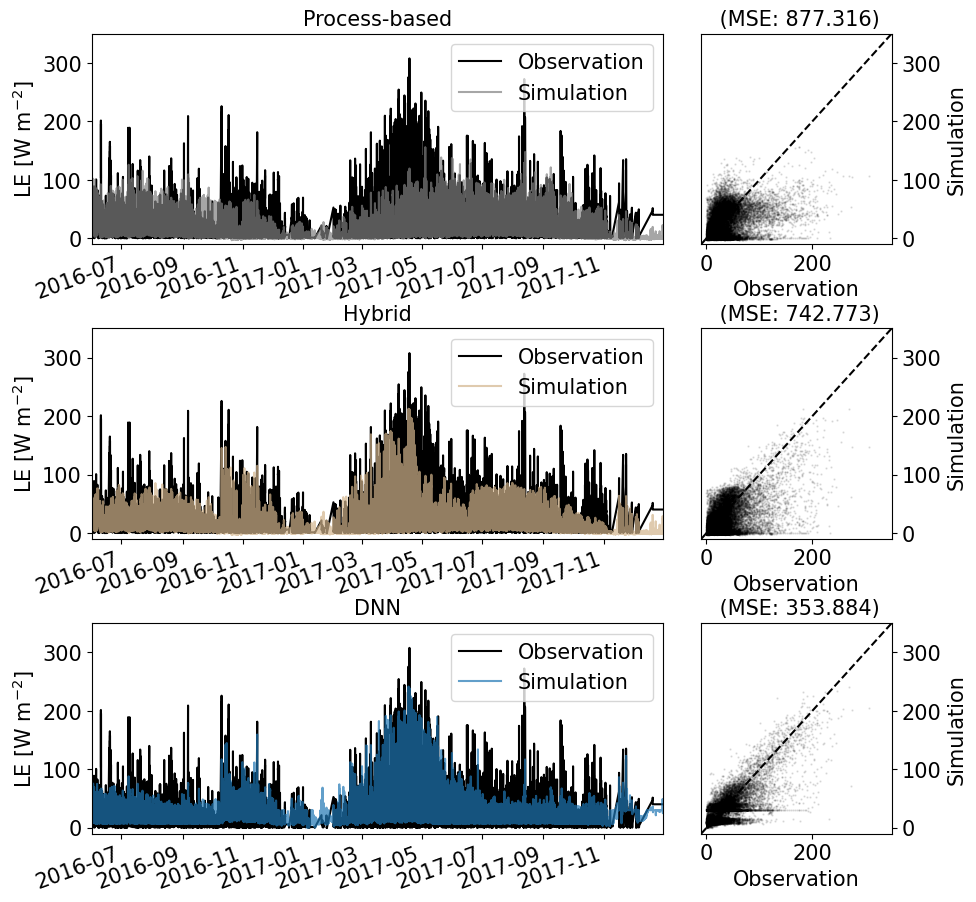

In [17]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(
    3, 2, width_ratios=(3, 1), left=0.1, right=0.9,
    bottom=0.1, top=0.9, wspace=0.1, hspace=0.4,
)

for i,name in enumerate(model_names[1:]):
    label = model_labels[i+1]
    # Get the axes
    ax1 = fig.add_subplot(gs[i, 0])
    ax2 = fig.add_subplot(gs[i, 1], sharey=ax1)

    # Get the time steps/data
    timesteps = get_time(met)
    start = timesteps[0]
    val1, val2 = obs.LE, configs[name]['train']['can.LE']
    lim = [-10, 350]

    # Observations
    plot_timeseries(
        val1, timesteps=timesteps, ax=ax1, title=None, label="Observation", 
        alpha=1.0, tunit="", linestyle='-', color='black'
    )

    # Simulations
    plot_timeseries(
        val2, timesteps=timesteps, ax=ax1, title=None, label="Simulation",
        alpha=0.7, tunit="", linestyle='-', color=model_colors[i]
    )

    # 1 to 1 plot
    plot_obs_1to1(val1, val2, lim, ax=ax2, varn="")

    ax1.legend()
    ax1.set(ylabel='LE [W m$^{-2}$]', title=label, xlabel='Time' if i == 3 else '')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=20, ha="right")
    ax2.set(ylabel='Simulation')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()

plt.show()  
# plot_timeseries_obs_1to1(
#     obs_test.LE,
#     configs[name]['test']['can.LE'],
#     lim=[-100, 200],
#     met=met_test,
#     varn="Latent heat fluxes [W m-2]",
# );


## Plot heatmaps of stomatal conductance

/tmp/ipykernel_911035/36891048.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
/global/cfs/cdirs/m1800/peishi/jax-watershed/src/jax_canoak/shared_utilities/plot.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/global/cfs/cdirs/m1800/peishi/jax-watershed/src/jax_canoak/shared_utilities/plot.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


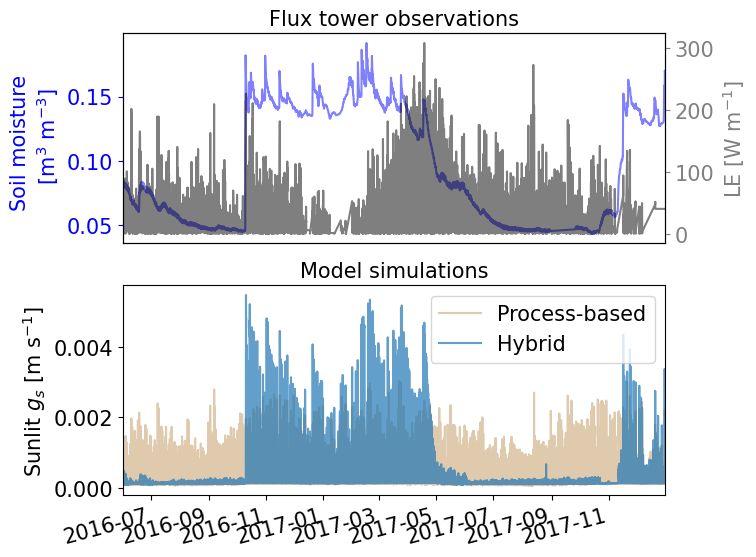

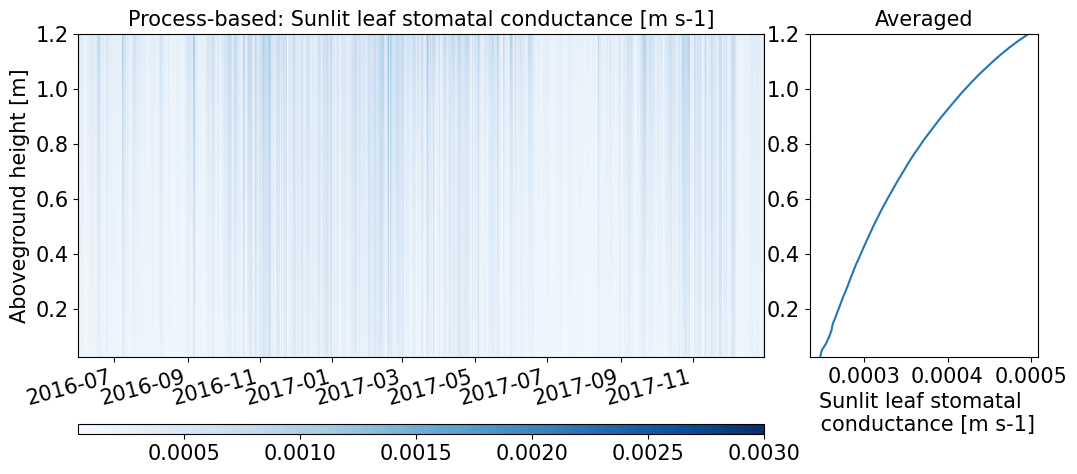

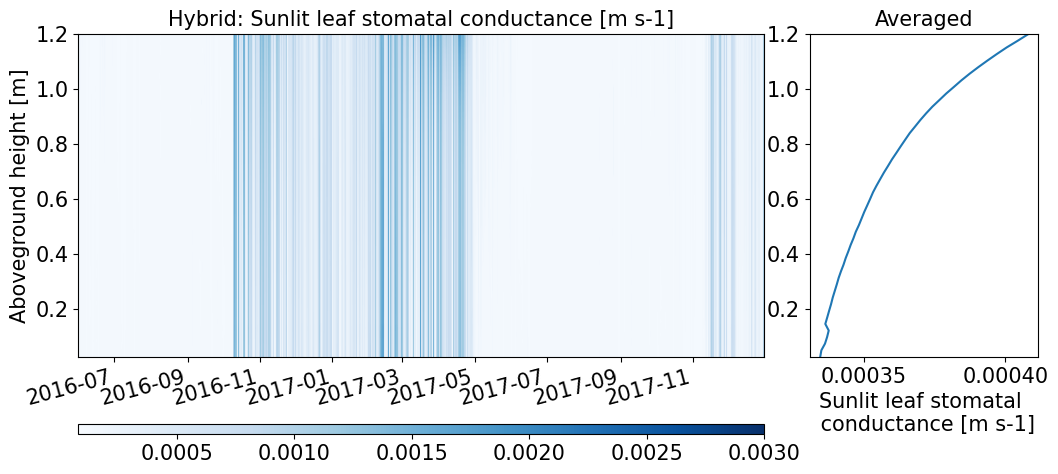

In [68]:
# Plot the observation data
fig, axes = plt.subplots(2, 1, figsize=(7, 6))
times = get_time(met)

# # latent heat flux
# ax = axes[0]
# plot_timeseries(
#     obs.LE, times, ax=ax, title='', alpha=1., color='black', tunit="", xticks=[]
# )
# ax.set(xlabel='', ylabel='LE [W m-2]', title='Flux tower observations')

# Flux tower observations
ax = axes[0]
ax_twinx = ax.twinx()
plot_timeseries(
    met.soilmoisture, times, ax=ax, title='', alpha=0.5, color='blue', tunit="[day of year]", xticks=[]
)
plot_timeseries(
    # met.vpd_Pa, times, ax=ax_twinx, title='', alpha=.5, color='black', tunit="[day of year]", xticks=[]
    obs.LE, times, ax=ax_twinx, title='', alpha=.5, color='black', tunit="", xticks=[]
)
ax.set(xlabel='', ylabel='Soil moisture \n [m$^{3}$ m$^{-3}$]', title='Flux tower observations')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
ax_twinx.set(xlabel='', ylabel='LE [W m$^{-1}$]')
ax_twinx.yaxis.label.set_color('grey')
ax_twinx.tick_params(axis='y', colors='grey')

# Model observations
ax = axes[1]
sun_gs_1 = configs['purephysics']['train']['sun.gs'].mean(axis=1)
sun_gs_2 = configs['hybridRH']['train']['sun.gs'].mean(axis=1)
ax.plot(times, sun_gs_1, color=model_colors[1], alpha=0.7, label=model_labels[1])
ax.plot(times, sun_gs_2, color=model_colors[2], alpha=0.7, label=model_labels[2])
ax.set(xlabel='', ylabel='Sunlit $g_s$ [m s$^{-1}$]', title='Model simulations', xlim=[times[0],times[-1]])
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
ax.legend(ncol=1, loc='upper right')

# # Scatter plots
# fig, ax = plt.subplots(1, 1, figsize=(8,5))
# ax.scatter(met.soilmoisture, met.vpd_Pa)

# Heatmap plots
for i,name in enumerate(model_names[1:-1]):
    # Get time and data
    times = get_time(met)
    can = configs[name]['train']['sun.gs'].T
    label = model_labels[i+1]
    
    axes, im = plot_imshow(
        can,
        met,
        models[name].para.zht1,
        cmap="Blues",
        axes=None,
        title=f"{label}: Sunlit leaf stomatal conductance [m s-1]",
        tunit="[day of year]",
        is_canopy=True,
        vmin=None,
        vmax=0.003,
    )
    axes[1].set(xlabel='Sunlit leaf stomatal \n conductance [m s-1]');
    

In [145]:
# for name in model_names[:-1]:
#     # Get time and data
#     times = get_time(met)
#     can = configs[name]['train']['sun.gs'].T
    
#     # Plot
#     axes, im = plot_imshow2(
#         can,
#         met,
#         models[name].para.zht1,
#         key="swc",
#         title="Sunlit leaf stomatal conductance [m/s]",
#         cmap="Blues",
#         vmax=0.002
#     )
#     ax0 = axes[0]
#     ax0_twin = ax0.twinx()
#     plot_timeseries(
#         # obs.LE, times, ax=ax0_twin, title='', alpha=0.5, color='black', tunit="[day of year]", xticks=[]
#         met.vpd*20, times, ax=ax0_twin, title='', alpha=0.5, color='black', tunit="[day of year]", xticks=[]
#     )
#     plot_timeseries(
#         obs.LE, times, ax=ax0_twin, title='', alpha=0.5, color='grey', tunit="[day of year]", xticks=[]
#         # met.vpd, times, ax=ax0_twin, title='', alpha=0.5, color='black', tunit="[day of year]", xticks=[]
#     )
#     axes[2].set(xlabel='Sunlit leaf stomatal \n conductance [m/s]')


## Plot heatmaps of photosynthesis

/global/cfs/cdirs/m1800/peishi/jax-watershed/src/jax_canoak/shared_utilities/plot.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/global/cfs/cdirs/m1800/peishi/jax-watershed/src/jax_canoak/shared_utilities/plot.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


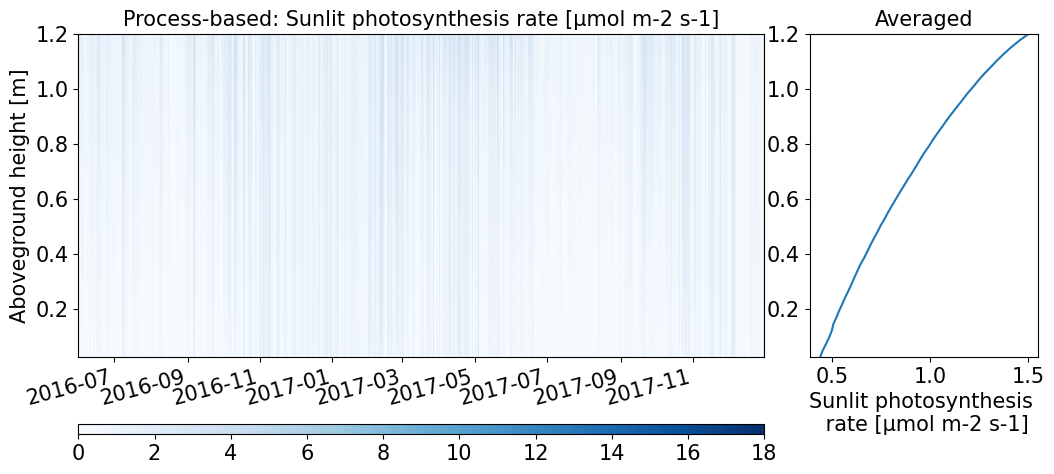

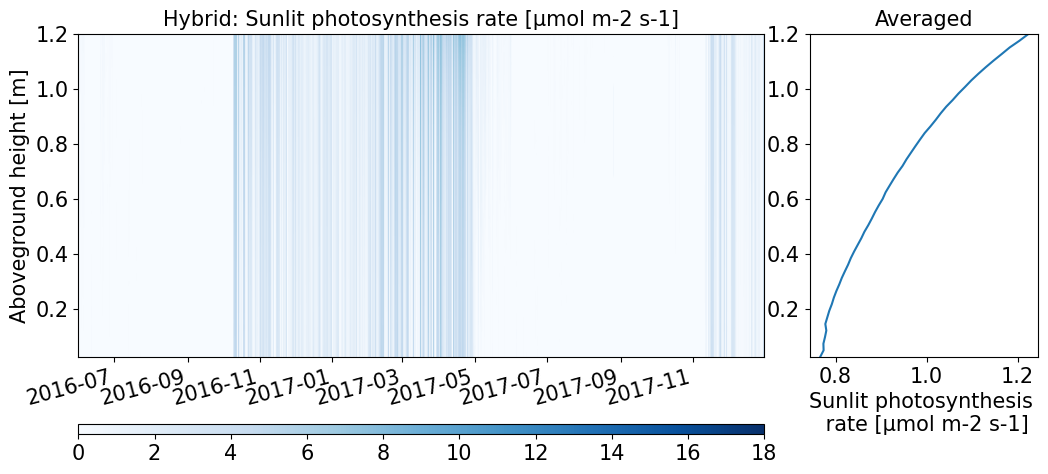

In [69]:
# Heatmap plots
for name in model_names[1:-1]:
    label = model_labels[model_names.index(name)]
    # Get time and data
    times = get_time(met)
    can = configs[name]['train']['sun.Ps'].T
    
    axes, im = plot_imshow(
        can,
        met,
        models[name].para.zht1,
        cmap="Blues",
        axes=None,
        title=f"{label}: Sunlit photosynthesis rate [μmol m-2 s-1]",
        tunit="[day of year]",
        is_canopy=True,
        vmin=0,
        vmax=18,
    )
    axes[1].set(xlabel='Sunlit photosynthesis \n rate [μmol m-2 s-1]');



## Plot GPP

/tmp/ipykernel_911035/1789481934.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=17, ha="right");
/tmp/ipykernel_911035/1789481934.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=17, ha="right");


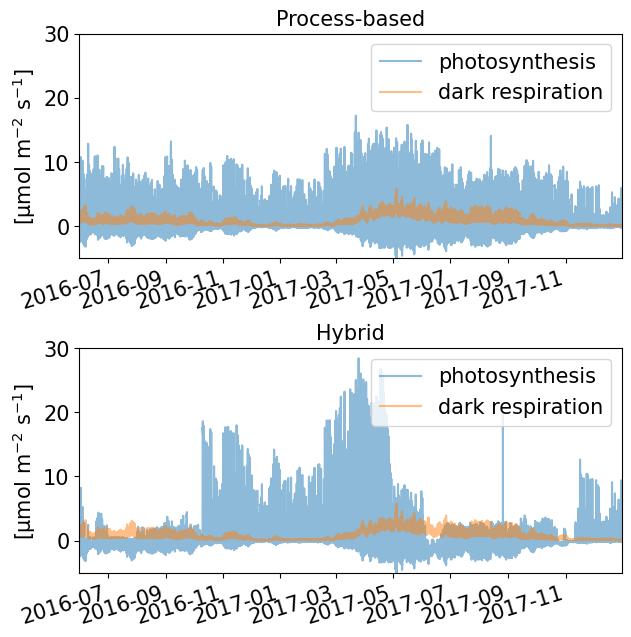

In [20]:
# Get time and data
times = get_time(met)
fig, axes = plt.subplots(2, 1, figsize=(7,7), sharex=False, sharey=True)

for i,name in enumerate(['purephysics', 'hybridRH']):
    label = model_labels[model_names.index(name)]
    ax = axes[i]
    ax.plot(times, sim[name][0][-2].Ps, alpha=0.5, label='photosynthesis')
    ax.plot(times, sim[name][0][-2].Rd, alpha=0.5, label='dark respiration')
    ax.set(xlim=[times[0], times[-1]], ylim=[-5, 30], ylabel='[µmol m$^{-2}$ s$^{-1}$]', title=label)
    ax.legend(loc='upper right')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=17, ha="right");
plt.subplots_adjust(hspace=0.4)
# ax = axes[1]
# # ax.plot(times, sim['hybridRH'][0][-2].GPP, alpha=0.5, label='GPP')
# ax.plot(times, sim['hybridRH'][0][-2].Ps, alpha=0.5, label='photosynthesis')
# ax.plot(times, sim['hybridRH'][0][-2].Rd, alpha=0.5, label='dark respiration')
# ax.set(xlim=[times[0], times[-1]], ylim=[-5, 30], title='Photosynthesis and dark respiration')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right");


## Multi-objective optimization issue

In [32]:
metrics_keys = ["rmse", "mse", "r2", "kge", "mkge", "cc", "nse"]
varns_interest = ['LE', 'H', 'Rnet', 'G', 'NEE']
metric = 'mse'
multi_metrics_df = pd.DataFrame(columns=varns_interest, index=model_labels[:-1])
for name in model_names[:-1]:
    label = model_labels[model_names.index(name)]
    metrics_le = compute_metrics(obs.LE, configs[name]['train']['can.LE'])[metric]
    metrics_h = compute_metrics(obs.H, configs[name]['train']['can.H'])[metric]
    metrics_rn = compute_metrics(obs.rnet, configs[name]['train']['can.rnet'])[metric]
    metrics_g = compute_metrics(obs.gsoil, configs[name]['train']['can.gsoil'])[metric]
    # metrics_nee = compute_metrics(obs.Fco2, configs[name]['train']['can.NEE'])[metric]
    metrics_nee = compute_metrics(obs.Fco2, sim[name][0][-1].NEE)[metric]
    multi_metrics_df.loc[label, 'LE'] = metrics_le
    multi_metrics_df.loc[label, 'H'] = metrics_h
    multi_metrics_df.loc[label, 'Rnet'] = metrics_rn
    multi_metrics_df.loc[label, 'G'] = metrics_g
    multi_metrics_df.loc[label, 'NEE'] = metrics_nee

multi_metrics_df


,LE,H,Rnet,G,NEE
Default,14778.761026,5775.133905,1528.07191,773.739375,79.349136
Process-based,877.315946,5462.908143,1095.91773,734.210574,24.53484
Hybrid,742.773437,5489.20262,1089.815407,737.13665,25.808141


/tmp/ipykernel_911035/1456297527.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=17, ha="right");
/tmp/ipykernel_911035/1456297527.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=17, ha="right");


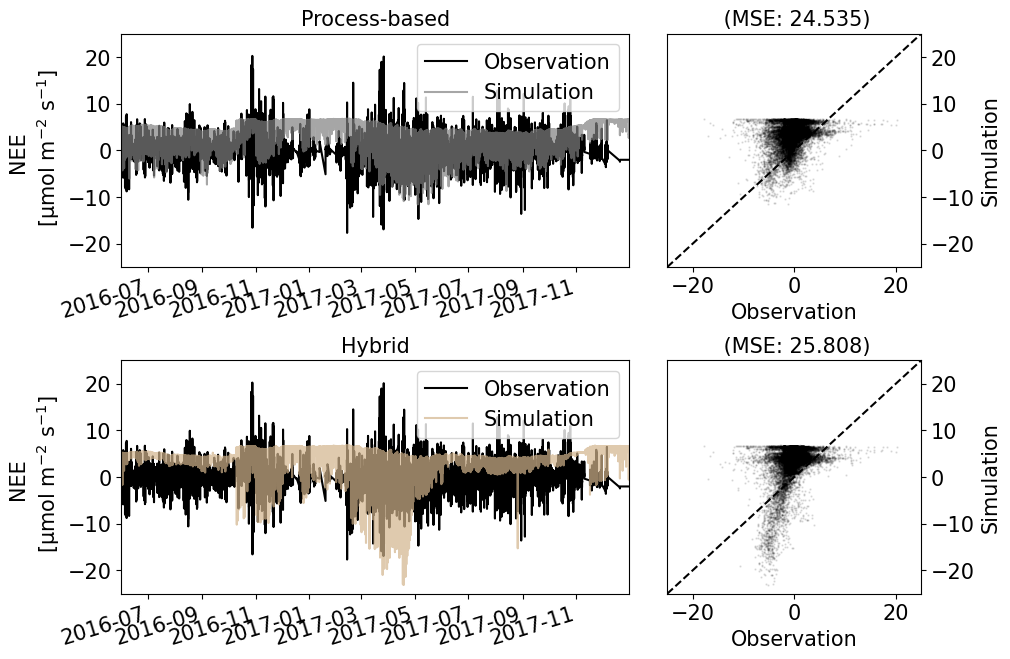

In [21]:
# Carbon fluxes
fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(
    2, 2, width_ratios=(2, 1), left=0.1, right=0.9,
    bottom=0.1, top=0.9, wspace=0.1, hspace=0.4,
)

for i,name in enumerate(model_names[1:3]):
    label = model_labels[model_names.index(name)]
    
    # Get the axes
    ax1 = fig.add_subplot(gs[i, 0])
    ax2 = fig.add_subplot(gs[i, 1], sharey=ax1)

    # Get the time steps/data
    timesteps = get_time(met)
    start = timesteps[0]
    val1, val2 = obs.Fco2, sim[name][0][-1].NEE
    lim = [-25, 25]

    # Observations
    plot_timeseries(
        val1, timesteps=timesteps, ax=ax1, title=None, label="Observation", 
        alpha=1.0, tunit="", linestyle='-', color='black'
    )

    # Simulations
    plot_timeseries(
        val2, timesteps=timesteps, ax=ax1, title=None, label="Simulation",
        alpha=0.7, tunit="", linestyle='-', color=model_colors[i]
    )

    # 1 to 1 plot
    plot_obs_1to1(val1, val2, lim, ax=ax2, varn="")

    ax1.legend()
    ax1.set(ylabel='NEE \n [µmol m$^{-2}$ s$^{-1}$]', title=label, xlabel='Time' if i == 3 else '')
    # if i == 0: ax1.set_xticks([])
    ax2.set(ylabel='Simulation')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=17, ha="right");



In [33]:
# pd.melt(multi_metrics_df, ignore_index=False)
multi_metrics_df_melt = multi_metrics_df
multi_metrics_df_melt['model'] = multi_metrics_df_melt.index
multi_metrics_df_melt = multi_metrics_df_melt.melt('model', var_name='Variable', value_name='Val')
multi_metrics_df_melt

,model,Variable,Val
0,Default,LE,14778.761026
1,Process-based,LE,877.315946
2,Hybrid,LE,742.773437
3,Default,H,5775.133905
4,Process-based,H,5462.908143
5,Hybrid,H,5489.20262
6,Default,Rnet,1528.07191
7,Process-based,Rnet,1095.91773
8,Hybrid,Rnet,1089.815407
9,Default,G,773.739375


/tmp/ipykernel_911035/3993545938.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(ylabel='MSE', ylim=[0, 6000], xticklabels=['$LE$', '$H$', '$R_n$', '$G$']);


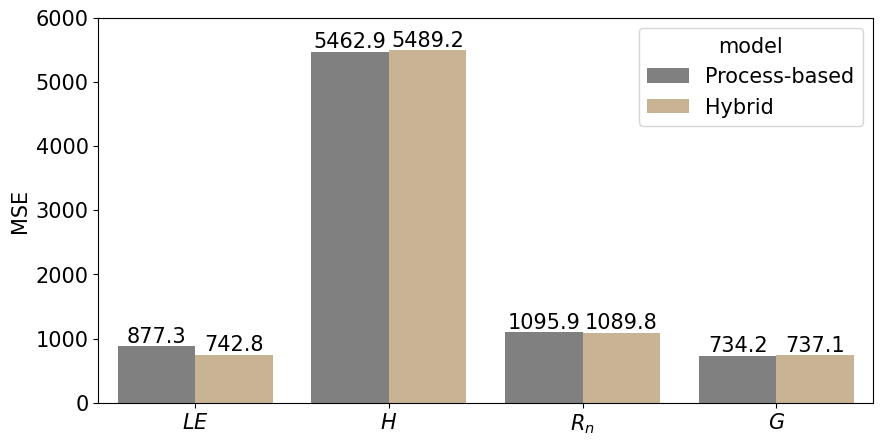

In [51]:
metrics_plot = multi_metrics_df_melt[
    multi_metrics_df_melt['model'].isin(['Process-based','Hybrid']) &
    multi_metrics_df_melt['Variable'].isin(['LE','H','Rnet','G']) 
]

fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.barplot(metrics_plot, ax=ax, x="Variable", y="Val", hue="model", palette=model_colors[:2])
ax.set(ylabel=metric, xlabel='');
for i in ax.containers:
    ax.bar_label(i,fmt='%.1f')
ax.set(ylabel='MSE', ylim=[0, 6000], xticklabels=['$LE$', '$H$', '$R_n$', '$G$']);


In [ ]:
obs.

In [ ]:
fig = plt.figure(figsize=(10, 7))
# gs = fig.add_gridspec(
#     3, 2, width_ratios=(3, 1), left=0.1, right=0.9,
#     bottom=0.1, top=0.9, wspace=0.1, hspace=0.4,
# )
fig, axes = plt.subplots(4, 2, figsize=(10,20))

for i,name in enumerate(model_names[1:3]):
    label = model_labels[i+1]
    # Get the axes
    ax1 = axes[0,i]
    ax2 = axes[1,i]
    ax3 = axes[2,i]
    ax4 = axes[3,i]

    # Get the time steps/data
    timesteps = get_time(met)
    start = timesteps[0]
    
    # LE
    val1, val2 = obs.LE, configs[name]['train']['can.LE']
    lim = [-10, 350]
    plot_obs_1to1(val1, val2, lim, ax=ax1, varn="", alpha=0.5)

    # H
    val1, val2 = obs.H, configs[name]['train']['can.H']
    lim = [-10, 600]
    plot_obs_1to1(val1, val2, lim, ax=ax2, varn="", alpha=0.5)
    
    # Rnet
    val1, val2 = obs.rnet, configs[name]['train']['can.rnet']
    lim = [-10, 900]
    plot_obs_1to1(val1, val2, lim, ax=ax3, varn="", alpha=0.5)
    
    # G
    val1, val2 = obs.gsoil, configs[name]['train']['can.gsoil']
    lim = [-10, 200]
    plot_obs_1to1(val1, val2, lim, ax=ax4, varn="", alpha=0.5)
    
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')

for ax in axes[:,0]:
    ax.set(ylabel='Simulation \n [W m$^{-2}$]')
    
for ax in axes[-1,:]:
    ax.set(xlabel='Observation \n [W m$^{-2}$]')



<Figure size 1000x700 with 0 Axes>

In [161]:
# # Some layout stuff ----------------------------------------------
# # Initialize layout in polar coordinates
# fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

# # Set background color to white, both axis and figure.
# fig.patch.set_facecolor("white")
# ax.set_facecolor("white")
# a
# ax.set_theta_offset(1.2 * np.pi / 2)
# ax.set_ylim(-1500, 3500)

# # Add geometries to the plot -------------------------------------
# # See the zorder to manipulate which geometries are on top

# # Add bars to represent the cumulative track lengths
# ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.52, zorder=10)

# # Add dashed vertical lines. These are just references
# ax.vlines(ANGLES, 0, 3000, color=GREY12, ls=(0, (4, 4)), zorder=11)

# # Add dots to represent the mean gain
# ax.scatter(ANGLES, MEAN_GAIN, s=60, color=GREY12, zorder=11)

# # Add labels for the regions -------------------------------------
# # Note the 'wrap()' function.
# # The '5' means we want at most 5 consecutive letters in a word, 
# # but the 'break_long_words' means we don't want to break words 
# # longer than 5 characters.
# REGION = ["\n".join(wrap(r, 5, break_long_words=False)) for r in REGION]
# REGION

# # Set the labels
# ax.set_xticks(ANGLES)
# ax.set_xticklabels(REGION, size=12);
